<a href="https://colab.research.google.com/github/yosbel-penate/AppEFThreading/blob/master/T2V_LSTM_KalmanFilter_Funcional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pykalman mlflow

     |████████████████████████████████| 228 kB 7.2 MB/s 
     |████████████████████████████████| 15.5 MB 43.5 MB/s 
     |████████████████████████████████| 58 kB 7.3 MB/s 
     |████████████████████████████████| 180 kB 68.6 MB/s 
     |████████████████████████████████| 79 kB 10.0 MB/s 
     |████████████████████████████████| 596 kB 58.1 MB/s 
     |████████████████████████████████| 1.1 MB 49.6 MB/s 
     |████████████████████████████████| 146 kB 64.8 MB/s 
     |████████████████████████████████| 75 kB 6.3 MB/s 
     |████████████████████████████████| 52 kB 2.1 MB/s 
     |████████████████████████████████| 63 kB 2.7 MB/s 
  Created wheel for pykalman: filename=pykalman-0.9.5-py3-none-any.whl size=48461 sha256=47818bf25aaff912a87e748ae231e379f4a3d70331be1f8318f26b2fc1d053c0
  Stored in directory: /root/.cache/pip/wheels/6a/04/02/2dda6ea59c66d9e685affc8af3a31ad3a5d87b7311689efce6
  Created wheel for alembic: filename=alembic-1.4.1-py2.py3-none-any.whl size=158172 sha256=aba2fa324cce8e4642

In [2]:
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import mean_absolute_error

from typing import Tuple, Dict

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import * 
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

import os

from mlflow import log_metric, log_param, log_artifacts

import warnings
warnings.filterwarnings("ignore")

from pykalman import KalmanFilter

In [3]:
CRIPTO = 'ADAEUR'
VELAS = '15m'
log_param("moneda", CRIPTO)
log_param("velas", VELAS)

SEQUENCE_LENGHT = 100

param = {
    'unit': 50,
    't2v_dim': 50,
    'lr': 1e-2, 
    'act': 'relu', 
    'epochs': 300,
    'batch_size': 100
}


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dir='/content/drive/MyDrive/Maestria 2 año 1 semestre/Инструментальные платформы прогнозной аналитики (Куляница Андрей Леонидович)/'
dataSetFile='2021.csv'
df = pd.read_csv(dir+dataSetFile)

In [6]:
df.shape

(500, 8)

In [7]:
df.head()

,Unnamed: 0,time,open,high,low,close,volume,date
0,0,1.637779e+12,1.629,1.631,1.615,1.615,1926807.4,1975-03-11 13:51:00
1,1,1.637780e+12,1.616,1.618,1.611,1.615,2393867.9,1975-03-11 13:52:30
2,2,1.637780e+12,1.614,1.618,1.601,1.605,3254583.7,1975-03-11 13:54:00
3,3,1.637781e+12,1.605,1.614,1.604,1.607,2101630.6,1975-03-11 13:55:30
4,4,1.637782e+12,1.607,1.620,1.606,1.618,1992281.9,1975-03-11 13:57:00


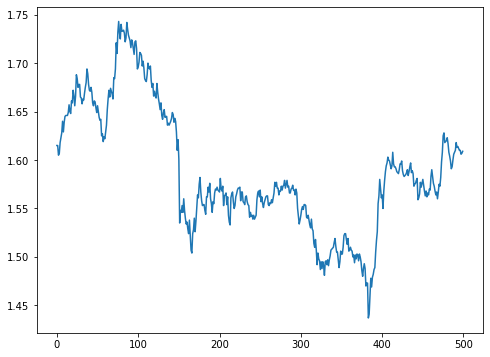

In [8]:
df['close'].plot( figsize=(8,6))

In [9]:
def KalmanTransform(df: pd.DataFrame,variable: str = 'close') -> None:
    kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean =df['{}'.format(variable)].values.mean(),
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.05)
    state_means, _ = kf.filter(df[variable].values)
    df['kalman'] = pd.Series(state_means.flatten(), index=df.index)

https://www.cienciadedatos.net/images/transform_timeseries.gif

In [10]:

def gen_sequence(id_df: pd.DataFrame, seq_length: int, seq_cols: str):
    
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        


def gen_labels(id_df: pd.DataFrame, seq_length: int, label: str):
    
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    
    return data_matrix[seq_length:num_elements, :]


Paper: https://arxiv.org/pdf/1907.05321.pdf




In [11]:
class T2V(Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)
        
    def build(self, input_shape):

        self.W = self.add_weight(name='W',
                                shape=(input_shape[-1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.P = self.add_weight(name='P',
                                shape=(input_shape[1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.w = self.add_weight(name='w',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        self.p = self.add_weight(name='p',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        super(T2V, self).build(input_shape)
        
    def call(self, x):
        
        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        
        return K.concatenate([sin_trans, original], -1)


### CREATE GENERATOR FOR LSTM AND T2V ###


def T2V_NN(param: Dict, dim: int = SEQUENCE_LENGHT):
    for key in param:
        log_param(key, param[key])
    inp = Input(shape=(dim,1))
    x = T2V(param['t2v_dim'])(inp)
    x = LSTM(param['unit'], activation=param['act'])(x)
    x = Dense(1)(x)
    
    m = Model(inp, x)
    m.compile(loss='mse', optimizer=Adam(lr=param['lr']))
    
    return m




In [12]:

### PREPARE DATA TO FEED MODELS ###
def PrepareData(df: pd.DataFrame, KALMAN: bool = False, predict_variable: str = 'close', sequence_length: int = SEQUENCE_LENGHT)-> Tuple:
    X, Y = [], []
    log_param("kalman", KALMAN)
    log_param('sequence_length',sequence_length)
    if KALMAN:
        KalmanTransform(df, predict_variable)
        for sequence in gen_sequence(df, sequence_length, ['kalman']):
            X.append(sequence)
    else:
        for sequence in gen_sequence(df, sequence_length, [predict_variable]):
            X.append(sequence)

    for sequence in gen_labels(df, sequence_length, [predict_variable]):
        Y.append(sequence)

    X = np.asarray(X)
    Y = np.asarray(Y)



    ### TRAIN TEST SPLIT ###

    train_dim = int(0.7*len(df))
    X_train, X_test = X[:train_dim], X[train_dim:]
    y_train, y_test = Y[:train_dim], Y[train_dim:]

    print('Train shape X: '+str(X_train.shape)+' y: '+str(y_train.shape))
    print('Test shape X: '+str(X_test.shape)+' y: '+str(y_test.shape))
    return (X_train,X_test,y_train,y_test)


In [13]:


### DEFINE PARAM GRID FOR HYPERPARM OPTIMIZATION ###



m=T2V_NN(param)
print(m.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 1)]          0         
                                                                 
 t2v (T2V)                   (None, 100, 51)           5250      
                                                                 
 lstm (LSTM)                 (None, 50)                20400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 25,701
Trainable params: 25,701
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
X_train,X_test,y_train,y_test=PrepareData(df,KALMAN=False)

Train shape X: (350, 100, 1) y: (350, 1)
Test shape X: (50, 100, 1) y: (50, 1)


In [15]:
historial=m.fit(X_train,y_train, batch_size=param['batch_size'],epochs=param['epochs'])

Epoch 1/300
4/4 [==============================] - 2s 66ms/step - loss: 1.5341
Epoch 2/300
4/4 [==============================] - 0s 73ms/step - loss: 1.7066
Epoch 3/300
4/4 [==============================] - 0s 69ms/step - loss: 1.4979
Epoch 4/300
4/4 [==============================] - 0s 71ms/step - loss: 0.4656
Epoch 5/300
4/4 [==============================] - 0s 63ms/step - loss: 0.1909
Epoch 6/300
4/4 [==============================] - 0s 65ms/step - loss: 0.0652
Epoch 7/300
4/4 [==============================] - 0s 73ms/step - loss: 0.0397
Epoch 8/300
4/4 [==============================] - 0s 68ms/step - loss: 0.0135
Epoch 9/300
4/4 [==============================] - 0s 66ms/step - loss: 0.0196
Epoch 10/300
4/4 [==============================] - 0s 65ms/step - loss: 0.0037
Epoch 11/300
4/4 [==============================] - 0s 78ms/step - loss: 0.0099
Epoch 12/300
4/4 [==============================] - 0s 73ms/step - loss: 0.0025
Epoch 13/300
4/4 [==============================]

In [16]:
pred = m.predict(X_test).ravel()


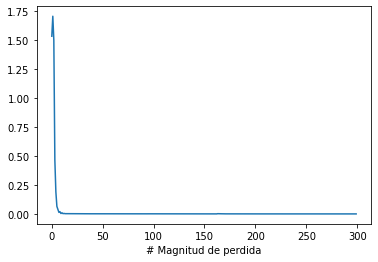

In [17]:
plt.xlabel('# Epoca')
plt.xlabel('# Magnitud de perdida')
plt.plot(historial.history["loss"])

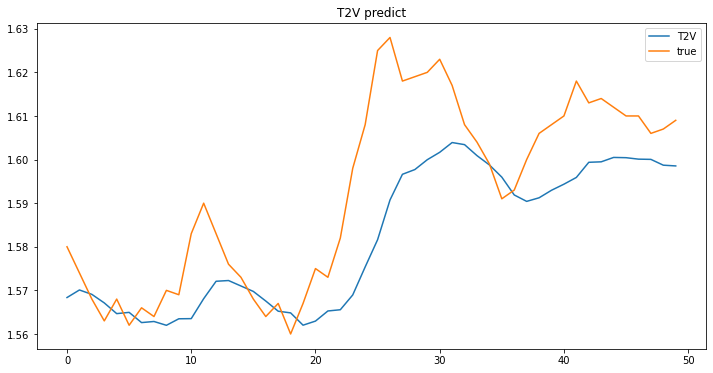

In [18]:
plt.figure(figsize=(12,6))

plt.plot(pred, label='T2V')
plt.plot(y_test.ravel(), label='true')
plt.title('T2V predict'); plt.legend()

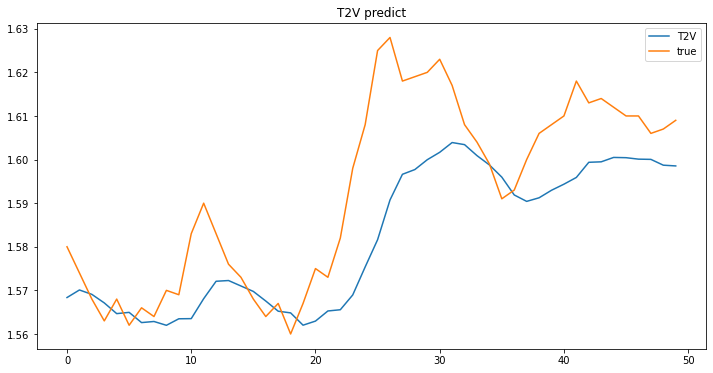

In [19]:
plt.figure(figsize=(12,6))

plt.plot(pred[:100], label='T2V')
plt.plot(y_test[:100].ravel(), label='true')
plt.title('T2V predict'); plt.legend()

In [20]:
print(mean_absolute_error(y_test.ravel(), pred))
log_metric("MAE",mean_absolute_error(y_test.ravel(), pred)) 

0.011414381351470984


In [ ]:
!mlflow ui

[2021-12-05 20:00:08 +0000] [729] [INFO] Starting gunicorn 20.1.0
[2021-12-05 20:00:08 +0000] [729] [INFO] Listening at: http://127.0.0.1:5000 (729)
[2021-12-05 20:00:08 +0000] [729] [INFO] Using worker: sync
[2021-12-05 20:00:08 +0000] [732] [INFO] Booting worker with pid: 732
